In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import os, sys
from time import time

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import statsmodels.api as sm
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import scale
import lightgbm as lgb
from scipy.stats import spearmanr
from tqdm import tqdm
import shap

import matplotlib.pyplot as plt
import seaborn as sns
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils4t import MultipleTimeSeriesCV
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)
results_path = Path('results')
if not results_path.exists():
    results_path.mkdir()

In [2]:
factors = (pd.concat([pd.read_hdf('data/data_alpha_factor.h5', 'factors/common'),
                      pd.read_hdf('data/data_alpha_factor.h5', 'factors/formulaic')
                      .rename(columns=lambda x: f'alpha_{int(x):03}')], axis=1)
           .dropna(axis=1, thresh=100000).sort_index())
factors.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1255093 entries, ('A', Timestamp('2007-01-04 00:00:00')) to ('ZION', Timestamp('2016-12-29 00:00:00'))
Columns: 137 entries, sector to alpha_101
dtypes: float64(125), int32(12)
memory usage: 1.2+ GB


In [3]:
factors.tail(10)

sector    ret_01    ret_02    ret_03    ret_04    ret_05  \
ticker date                                                                   
ZION   2016-12-15     0.0  0.019905  0.019181  0.013421 -0.004395 -0.001160   
       2016-12-16     0.0 -0.023467 -0.004028 -0.004736 -0.010360 -0.027759   
       2016-12-19     0.0  0.015941 -0.007900  0.011848  0.011130  0.005416   
       2016-12-20     0.0  0.028337  0.044730  0.020214  0.040521  0.039782   
       2016-12-21     0.0 -0.006149  0.022014  0.038306  0.013941  0.034123   
       2016-12-22     0.0  0.002291 -0.003872  0.024356  0.040685  0.016264   
       2016-12-23     0.0  0.002743  0.005041 -0.001139  0.027166  0.043540   
       2016-12-27     0.0  0.001596  0.004344  0.006645  0.000455  0.028806   
       2016-12-28     0.0 -0.014796 -0.013224 -0.010517 -0.008249 -0.014348   
       2016-12-29     0.0 -0.011322 -0.025950 -0.024396 -0.021719 -0.019478   

                     ret_10    ret_21    ret_42    ret_63  ...  alpha_083  \
ticker date                                                ...              
ZION   2016-12-15  0.065083  0.110423  0.407165  0.442461  ...   0.054326   
       2016-12-16  0.044483  0.121997  0.351219  0.408612  ...   0.708249   
       2016-12-19  0.053021  0.126352  0.334234  0.432504  ...   0.309859   
       2016-12-20  0.047471  0.149176  0.363962  0.467203  ...   0.235412   
       2016-12-21  0.031922  0.132330  0.352222  0.444216  ...   0.830986   
       2016-12-22  0.015085  0.131402  0.351559  0.431919  ...   0.094567   
       2016-12-23  0.014573  0.121166  0.370053  0.464067  ...   0.082495   
       2016-12-27  0.034377  0.123529  0.369678  0.447598  ...   0.911469   
       2016-12-28  0.024864  0.126790  0.339410  0.405838  ...   0.364185   
       2016-12-29  0.013981  0.111429  0.336213  0.404950  ...   0.619718   

                   alpha_084  alpha_085  alpha_086  alpha_092  alpha_094  \
ticker date                                                                
ZION   2016-12-15   0.711694   0.103023          0        NaN  -0.570827   
       2016-12-16   0.247485   0.172803          0        NaN  -0.553320   
       2016-12-19   0.288032   0.326853          0        NaN  -0.565392   
       2016-12-20   0.793103   0.265142          0        NaN  -0.663984   
       2016-12-21   0.713131   0.276126          0        NaN  -0.417155   
       2016-12-22   0.787879   0.284896          0        NaN  -0.704225   
       2016-12-23   0.726721   0.120672          0        NaN  -0.760563   
       2016-12-27   0.776876   0.150294          0        NaN  -0.695124   
       2016-12-28   0.356137   0.211741          0        NaN  -0.615767   
       2016-12-29   0.171717   0.722987          0        NaN  -0.572352   

                   alpha_095  alpha_098  alpha_099  alpha_101  
ticker date                                                    
ZION   2016-12-15          1  -0.001054          0   0.191137  
       2016-12-16          1  -0.112446          0 -32.380420  
       2016-12-19          1  -0.126077         -1   0.662319  
       2016-12-20          1  -0.021919         -1   0.557026  
       2016-12-21          1  -0.069719         -1 -69.592806  
       2016-12-22          1  -0.139978         -1   0.161942  
       2016-12-23          1  -0.130715         -1   0.225985  
       2016-12-27          1  -0.057963         -1  -0.353426  
       2016-12-28          1   0.045870          0 -51.719691  
       2016-12-29          1   0.201444         -1 -42.783837  

[10 rows x 137 columns]

In [4]:
fwd_returns = factors.filter(like='fwd').columns
features = factors.columns.difference(fwd_returns).tolist()
alphas = pd.Index([f for f in features if f.startswith('alpha')])
features

['AARONOSC',
 'AD',
 'ADOSC',
 'ADX',
 'ADXR',
 'ALPHA_21',
 'ALPHA_252',
 'ALPHA_63',
 'ATR',
 'BB_LOW',
 'BB_SQUEEZE',
 'BB_UP',
 'BOP',
 'CCI',
 'CMA_21',
 'CMA_252',
 'CMA_63',
 'CMO',
 'HML_21',
 'HML_252',
 'HML_63',
 'HT',
 'MACD',
 'MACD_HIST',
 'MACD_SIGNAL',
 'MARKET_21',
 'MARKET_252',
 'MARKET_63',
 'MFI',
 'NATR',
 'OBV',
 'PPO',
 'RMW_21',
 'RMW_252',
 'RMW_63',
 'RSI',
 'SAR',
 'SMB_21',
 'SMB_252',
 'SMB_63',
 'STOCH',
 'STOCHRSI',
 'ULTOSC',
 'WILLR',
 'alpha_001',
 'alpha_002',
 'alpha_003',
 'alpha_004',
 'alpha_005',
 'alpha_006',
 'alpha_007',
 'alpha_008',
 'alpha_009',
 'alpha_010',
 'alpha_011',
 'alpha_012',
 'alpha_013',
 'alpha_014',
 'alpha_015',
 'alpha_016',
 'alpha_017',
 'alpha_018',
 'alpha_019',
 'alpha_020',
 'alpha_021',
 'alpha_022',
 'alpha_023',
 'alpha_024',
 'alpha_025',
 'alpha_026',
 'alpha_027',
 'alpha_028',
 'alpha_029',
 'alpha_030',
 'alpha_032',
 'alpha_033',
 'alpha_034',
 'alpha_035',
 'alpha_036',
 'alpha_037',
 'alpha_038',
 'alpha_0

In [5]:
len(alphas)

78

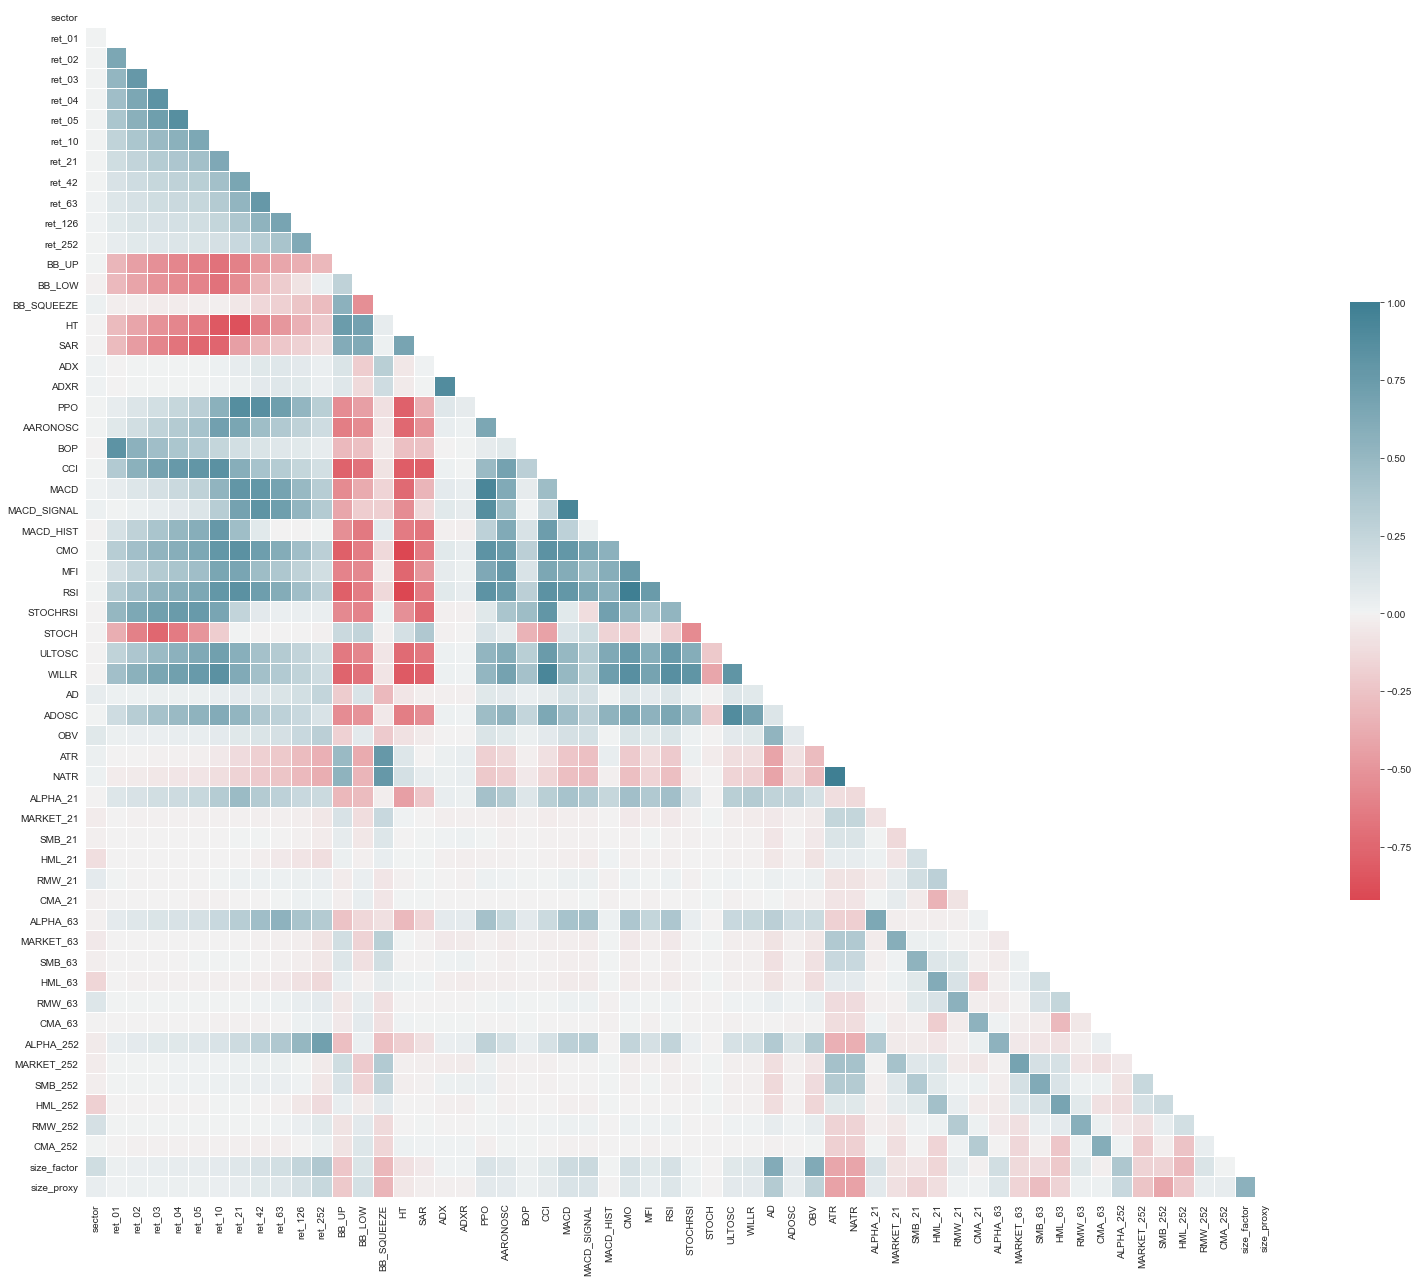

In [6]:
# Factor Correlation

# 'Classic' Factors
corr_common = factors.drop(fwd_returns.union(alphas), axis=1).corr(method='spearman')
corr_common.to_hdf('data/data_alpha_factor.h5', 'correlation/common')
mask = np.triu(np.ones_like(corr_common, dtype=np.bool))
fig, ax = plt.subplots(figsize=(22, 18))
cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(corr_common, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
fig.tight_layout()
fig.savefig(results_path / 'factor_corr_common', dpi=300);

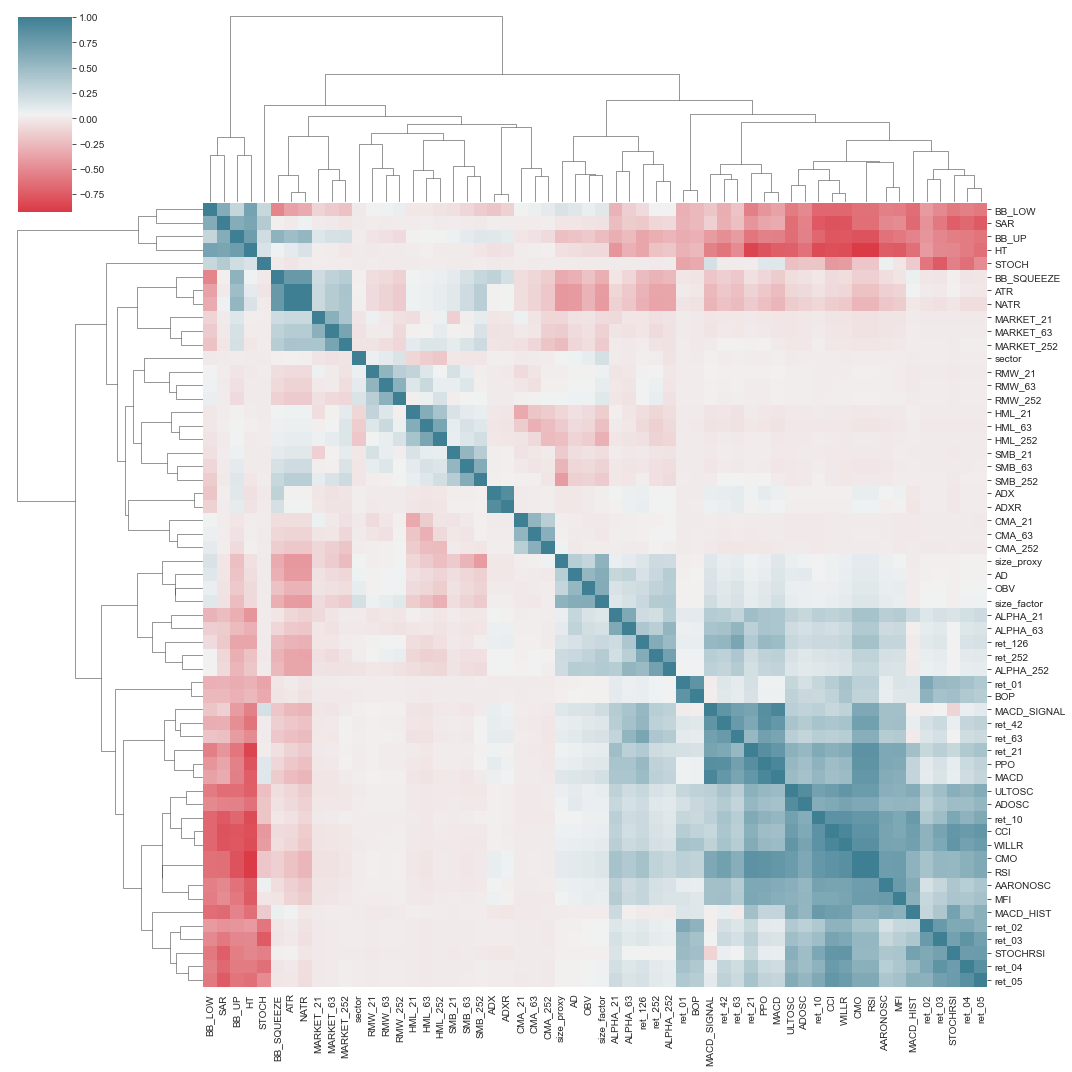

In [7]:
g = sns.clustermap(corr_common, cmap=cmap, figsize=(15, 15))
g.savefig(results_path / 'factor_corr_common_cluster', dpi=300);

In [8]:
corr_ = corr_common.stack().reset_index()
corr_.columns = ['x1', 'x2', 'rho']
corr_ = corr_[corr_.x1!=corr_.x2].drop_duplicates('rho')
corr_.nlargest(5, columns='rho').append(corr_.nsmallest(5, columns='rho'))

,x1,x2,rho
1536,CMO,RSI,1.000000
2125,ATR,NATR,0.997212
1358,MACD,MACD_SIGNAL,0.936793
1308,CCI,WILLR,0.925544
1125,PPO,MACD,0.925282
898,HT,RSI,-0.923566
896,HT,CMO,-0.923566
421,ret_21,HT,-0.866342
363,ret_10,HT,-0.828103
902,HT,WILLR,-0.825403


In [9]:
%%time
# Formulaic Alphas
corr_formula = factors[alphas].sort_index().corr(method='spearman').dropna(how='all', axis=1)
corr_formula.to_hdf('data/data_alpha_factor.h5', 'correlation/formula')

CPU times: total: 15min 3s
Wall time: 15min 23s


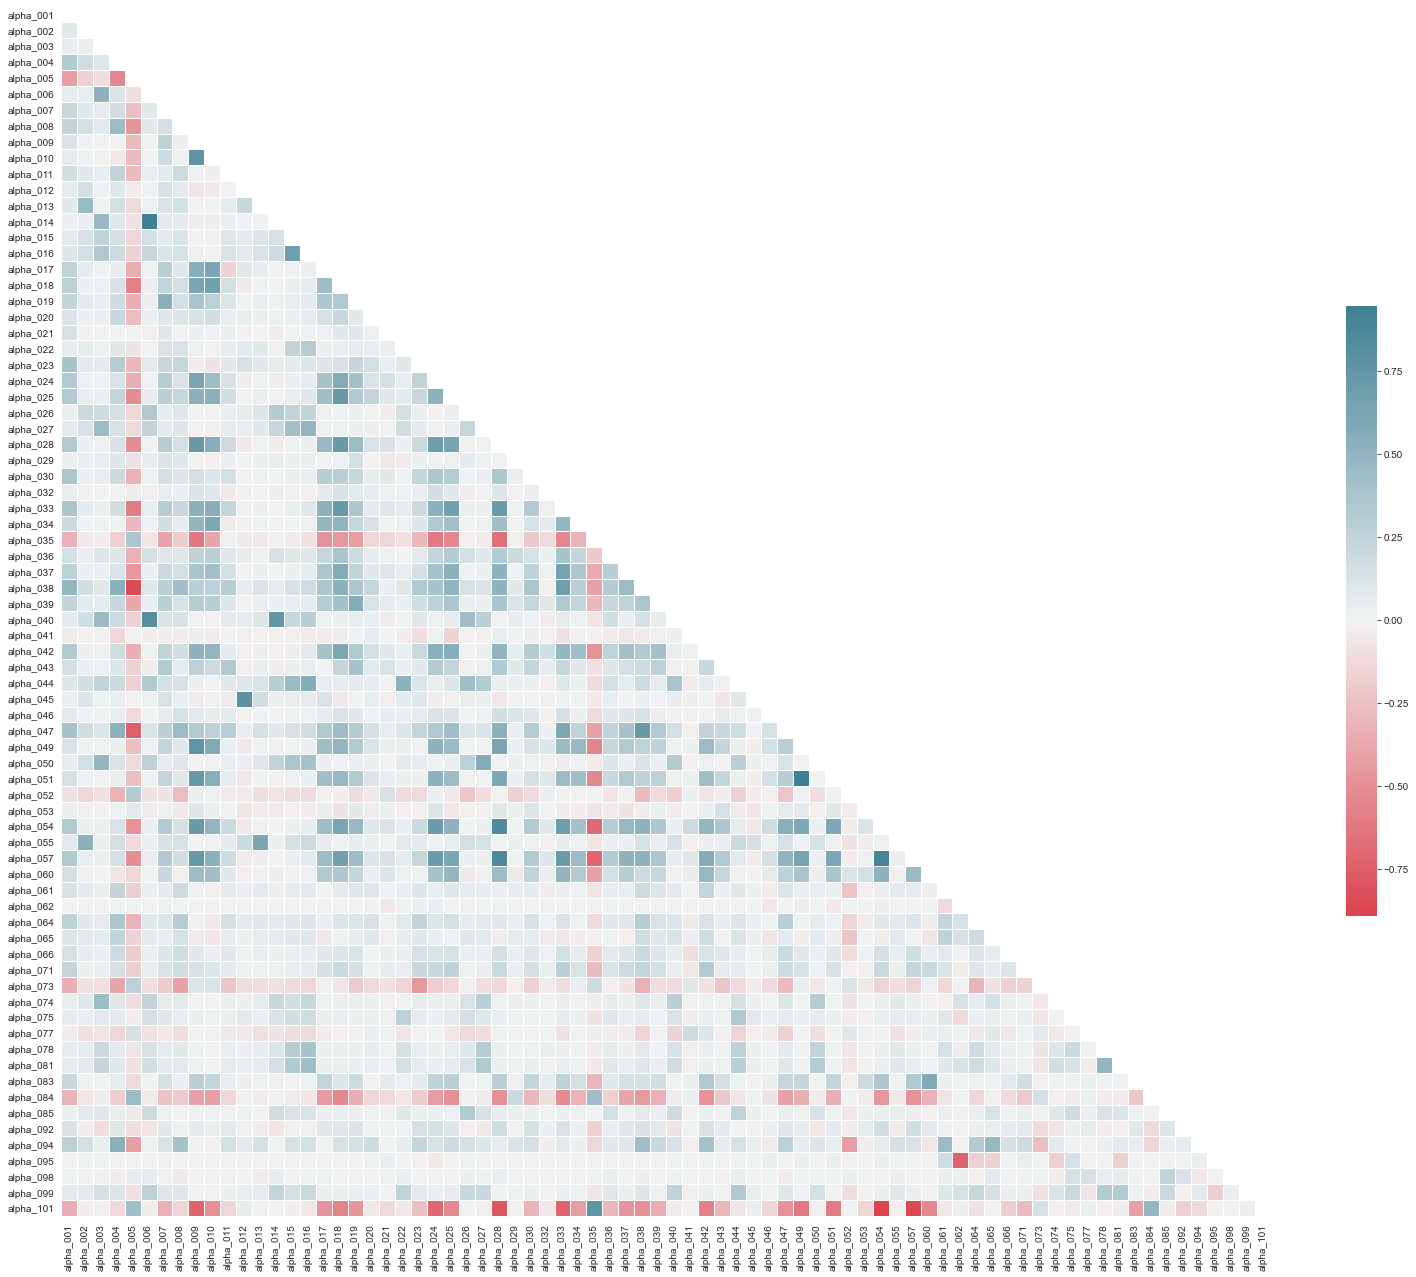

In [10]:
corr_formula = corr_formula.dropna(how='all').dropna(how='all', axis=1)
mask = np.triu(np.ones_like(corr_formula, dtype=np.bool))
fig, ax = plt.subplots(figsize=(22, 18))
cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(corr_formula, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
fig.tight_layout()
fig.savefig(results_path / 'factor_correlation_formula', dpi=300);

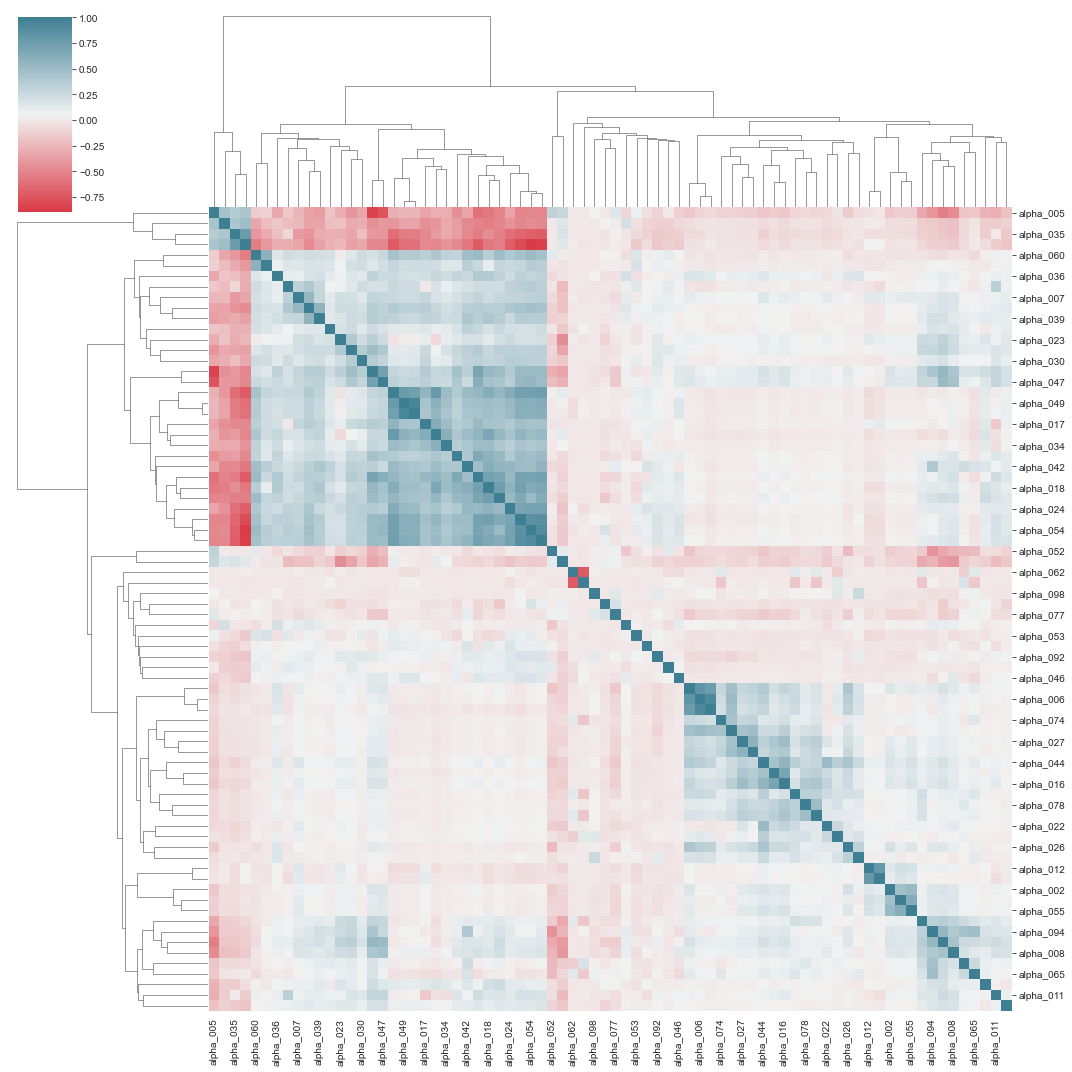

In [11]:
g = sns.clustermap(corr_formula.replace((np.inf, -np.inf), np.nan), cmap=cmap, figsize=(15, 15))
g.savefig(results_path / 'factor_correlation_formula_cluster', dpi=300);

In [12]:
corr_formula_ = corr_formula.stack().reset_index()
corr_formula_.columns = ['x1', 'x2', 'rho']
corr_formula_ = corr_formula_[corr_formula_.x1!=corr_formula_.x2].drop_duplicates('rho')
corr_formula_.nlargest(5, columns='rho').append(corr_formula_.nsmallest(5, columns='rho'))

,x1,x2,rho
3544,alpha_049,alpha_051,0.945057
393,alpha_006,alpha_014,0.919212
3929,alpha_054,alpha_057,0.898733
2105,alpha_028,alpha_057,0.852622
2103,alpha_028,alpha_054,0.846876
3951,alpha_054,alpha_101,-0.893442
4103,alpha_057,alpha_101,-0.869329
340,alpha_005,alpha_038,-0.855128
2127,alpha_028,alpha_101,-0.799556
349,alpha_005,alpha_047,-0.753112


In [13]:
# All Factors
corr = factors.drop(['ret_fwd', 'alpha_051'], axis=1).corr()
corr = corr.dropna(how='all').dropna(how='all', axis=1)
corr.to_hdf('data/data_alpha_factor.h5', 'correlation/all')
corr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133 entries, sector to alpha_101
Columns: 133 entries, sector to alpha_101
dtypes: float64(133)
memory usage: 139.2+ KB


In [14]:
corr.shape

(133, 133)

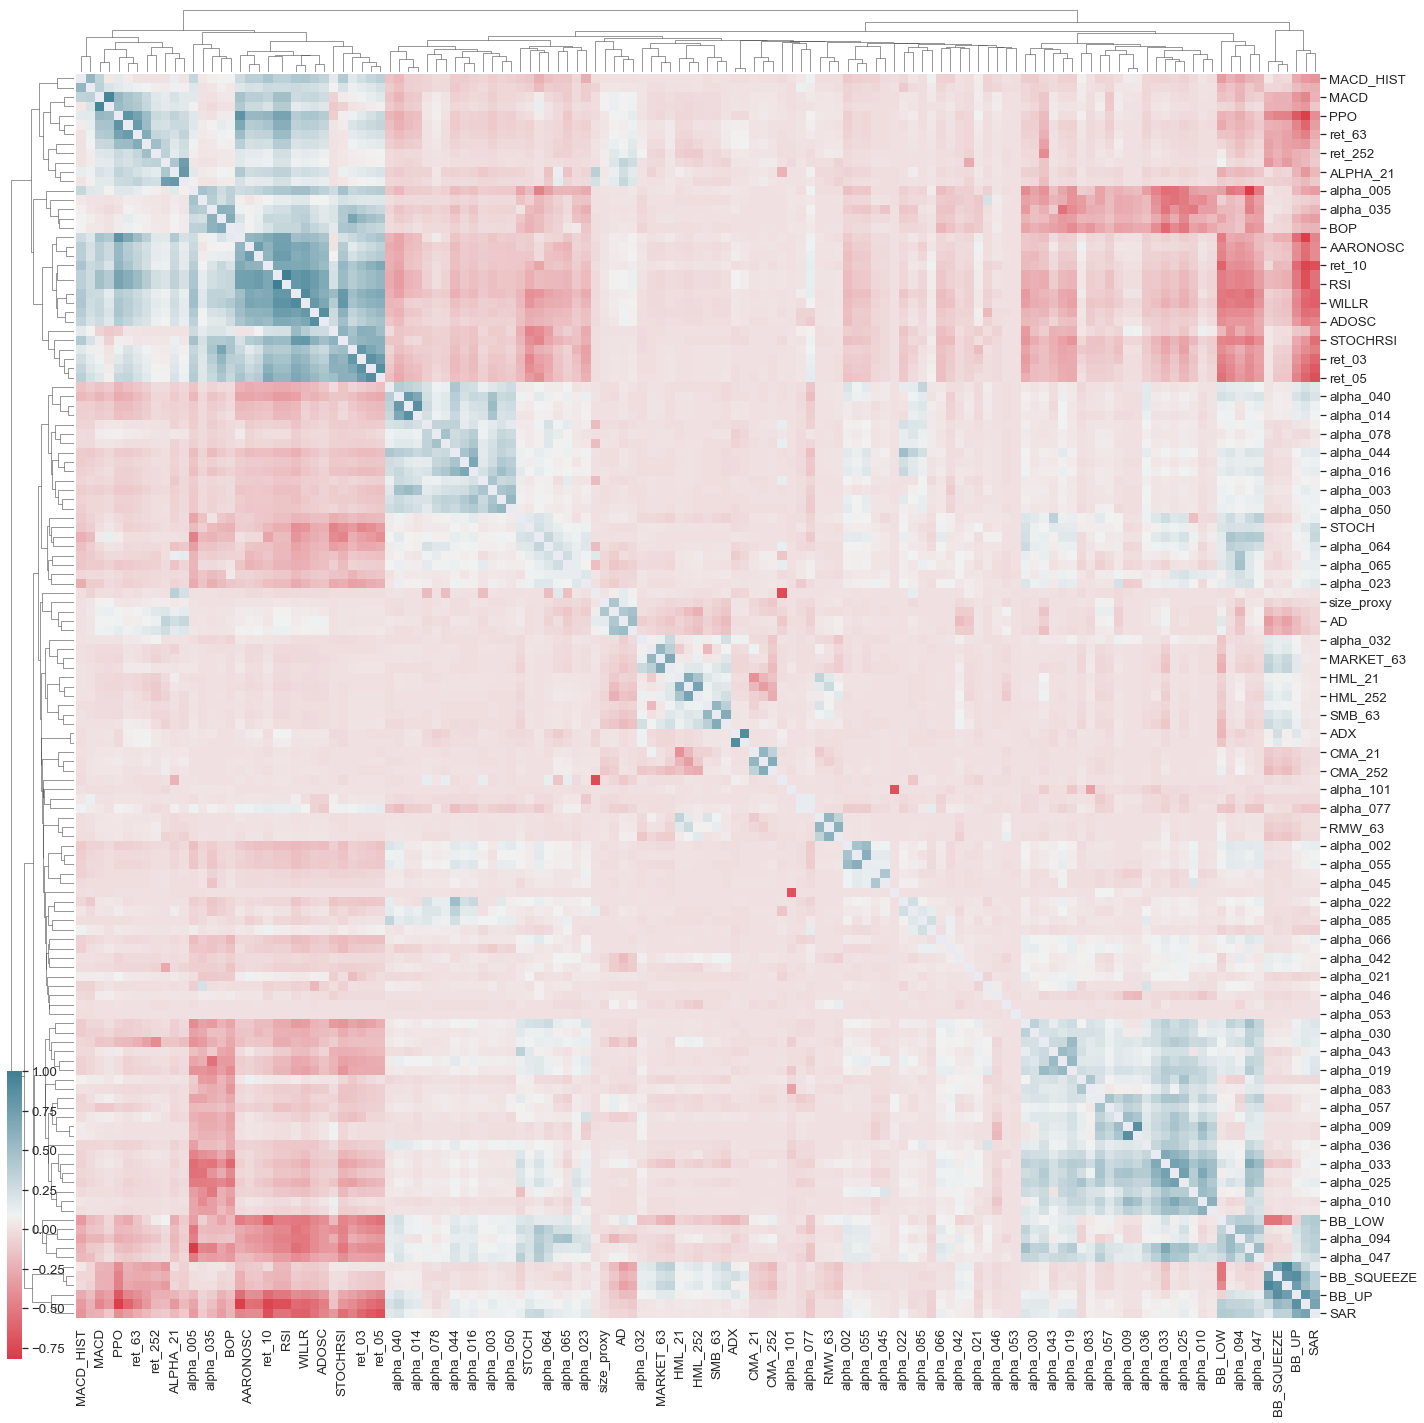

In [15]:
sns.set(font_scale=1.2)

mask = np.zeros_like(corr)
np.fill_diagonal(mask, 1)

g = sns.clustermap(corr, cmap=cmap, figsize=(20, 20), dendrogram_ratio=.05, mask=mask,
                   cbar_pos=(0.01, 0.05, 0.01, 0.2));

g.savefig(results_path / 'factor_correlation_all', dpi=300);

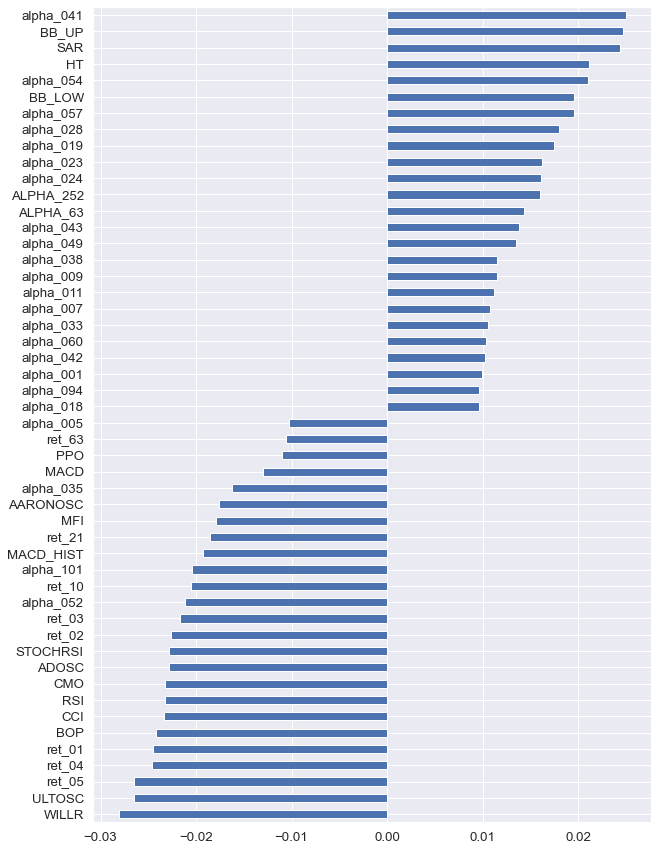

In [16]:
# Forward return correlation
fwd_corr = factors.drop(['ret_fwd', 'alpha_051'], axis=1).corrwith(factors.ret_fwd, method='spearman')
fwd_corr = fwd_corr.dropna()
fwd_corr.to_hdf('data/data_alpha_factor.h5', 'correlation/fwd_ret')
top50 = fwd_corr.abs().nlargest(50).index
fwd_corr.loc[top50].sort_values().plot.barh(figsize=(10, 15),
                                            legend=False);

In [17]:
# Mutual Information
mi = {}
for feature in tqdm(features):
    df = (factors.loc[:, ['ret_fwd', feature]].dropna().sample(n=100000))
    discrete_features = df[feature].nunique() < 10
    mi[feature] = mutual_info_regression(X=df[[feature]], y=df.ret_fwd, discrete_features=discrete_features)[0]
mi = pd.Series(mi)

100%|██████████| 136/136 [01:47<00:00,  1.27it/s]


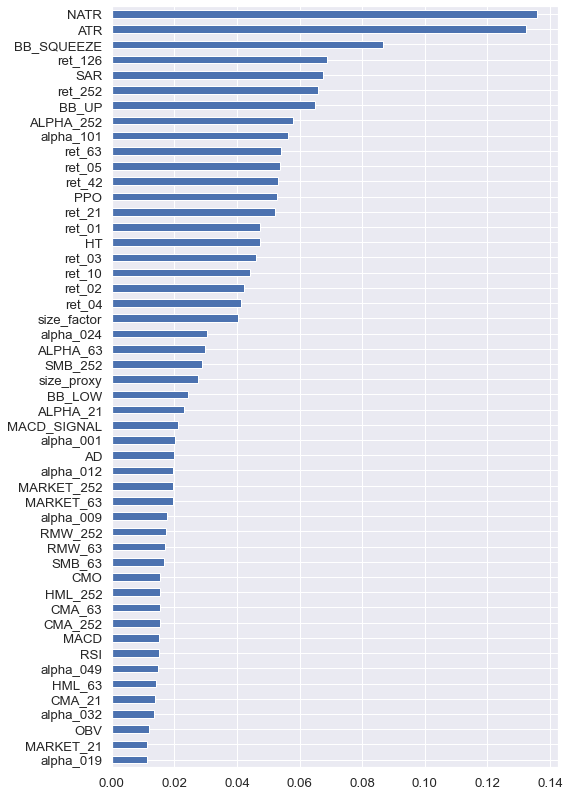

In [18]:
mi.nlargest(50).sort_values().plot.barh(figsize=(8, 14));

In [19]:
mi.to_hdf('data/data_alpha_factor.h5', 'mutual_information')

In [20]:
# LightGBM Feature Importance
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))
def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True
    return 'ic', spearmanr(preds, train_data.get_label())[0], is_higher_better
uniques = factors.nunique()
categoricals = uniques[uniques < 20].index.tolist()
categoricals

['sector',
 'alpha_004',
 'alpha_021',
 'alpha_027',
 'alpha_061',
 'alpha_062',
 'alpha_064',
 'alpha_065',
 'alpha_068',
 'alpha_073',
 'alpha_074',
 'alpha_075',
 'alpha_081',
 'alpha_086',
 'alpha_092',
 'alpha_095',
 'alpha_099']

In [22]:
features = factors.columns.difference(fwd_returns).tolist()
label = 'ret_fwd'
train_length = int(8.5 * 252)
test_length = 252
n_splits = 1
params = dict(boosting='gbdt', objective='regression', verbose=-1, metric='None')
num_boost_round = 5000
lgb_data = lgb.Dataset(data=factors.loc[:, features], label=factors.loc[:, label],
                       categorical_feature=categoricals, free_raw_data=False)

cv = MultipleTimeSeriesCV(n_splits=n_splits, lookahead=1, test_period_length=test_length,
                          train_period_length=train_length)

feature_importance, ic, daily_ic = [], [], []

for i, (train_idx, test_idx) in enumerate(cv.split(X=factors)):
    start = time()
    lgb_train = lgb_data.subset(used_indices=train_idx.tolist(), params=params).construct()
    lgb_test = lgb_data.subset(used_indices=test_idx.tolist(), params=params).construct()
    evals_result = {}
    model = lgb.train(params=params, train_set=lgb_train, num_boost_round=num_boost_round,
                      valid_sets=[lgb_train, lgb_test], valid_names=['train', 'valid'], feval=ic_lgbm,
                      evals_result=evals_result, early_stopping_rounds=500, verbose_eval=100)
    model.save_model(f'lgb_model.txt')
    fi = get_fi(model)
    fi.to_hdf('data/data_alpha_factor.h5', f'fi/{i:02}')
    test_set = factors.iloc[test_idx, :]
    X_test = test_set.loc[:, model.feature_name()]
    y_test = test_set.loc[:, label]
    y_pred = model.predict(X_test)
    cv_preds = y_test.to_frame('y_test').assign(y_pred=y_pred)
    cv_preds.to_hdf('preds.h5', f'preds/{i:02}')

    by_day = cv_preds.groupby(level='date')
    ic_by_day = by_day.apply(lambda x: spearmanr(x.y_test, x.y_pred)[0])
    daily_ic_mean = ic_by_day.mean()
    daily_ic_median = ic_by_day.median()
    ic = spearmanr(cv_preds.y_test, cv_preds.y_pred)[0]
    print(f'\n{time()-start:6.1f} | {ic:6.2%} | {daily_ic_mean: 6.2%} | {daily_ic_median: 6.2%}')

Training until validation scores don't improve for 500 rounds
[100]	train's ic: 0.147465	valid's ic: 0.00939385
[200]	train's ic: 0.196075	valid's ic: 0.0102923
[300]	train's ic: 0.23671	valid's ic: 0.00676514
[400]	train's ic: 0.267427	valid's ic: 0.00752386
[500]	train's ic: 0.287265	valid's ic: 0.00923358
[600]	train's ic: 0.307563	valid's ic: 0.011213
Early stopping, best iteration is:
[179]	train's ic: 0.186565	valid's ic: 0.0136968

 341.9 |  1.37% |  1.05% |  1.04%


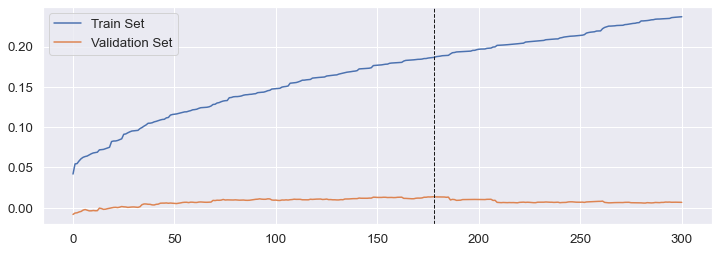

In [23]:
cv_result = pd.DataFrame({'Train Set': evals_result['train']['ic'],
                          'Validation Set': evals_result['valid']['ic']})

ax = cv_result.loc[:300].plot(figsize=(12, 4))
ax.axvline(cv_result['Validation Set'].idxmax(), c='k', ls='--', lw=1);

In [24]:
# SHAP Values
shap.initjs()

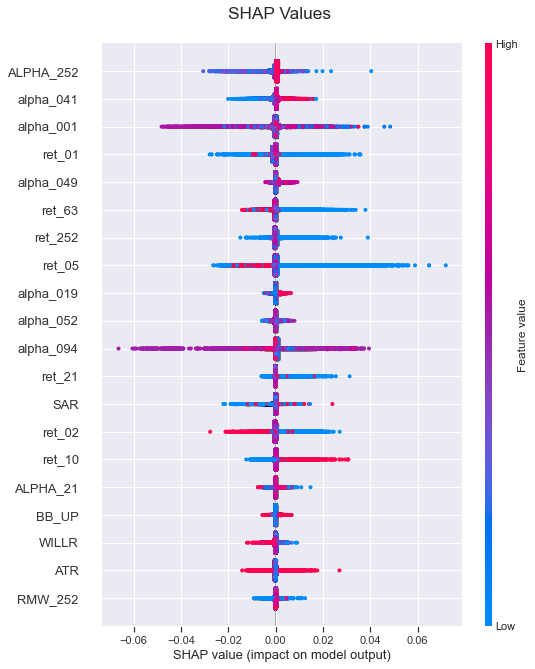

In [26]:
# model = lgb.Booster(model_file='lgb_model.txt')
explainer = shap.TreeExplainer(model)
# workaround for SHAP version 0.30: https://github.com/slundberg/shap/issues/794
model.params['objective'] = 'regression'
shap_values = explainer.shap_values(factors.iloc[train_idx, :].loc[:, model.feature_name()])
np.save('shap_values.npy', shap_values)
shap_values = np.load('shap_values.npy')
shap.summary_plot(shap_values, factors.iloc[train_idx, :].loc[:, model.feature_name()], show=False)
plt.gcf().suptitle('SHAP Values')
plt.gcf().tight_layout()
plt.gcf().savefig(results_path / 'shap_summary_dot', dpi=300)

In [27]:
shap_values = pd.DataFrame(shap_values, columns = features)

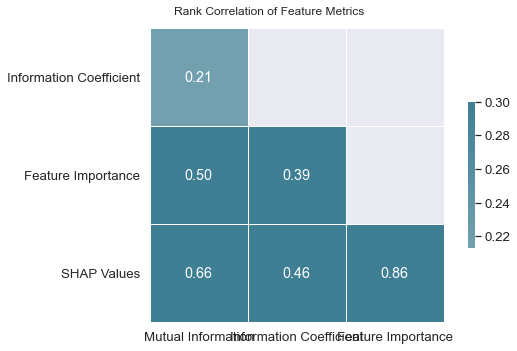

In [28]:
# Summary
mi = pd.read_hdf('data/data_alpha_factor.h5', 'mutual_information')
fwd_corr = pd.read_hdf('data/data_alpha_factor.h5', 'correlation/fwd_ret')
shap_summary = shap_values.abs().mean()
shap_summary /= shap_summary.sum()
stats = (mi.to_frame('Mutual Information').join(fwd_corr.to_frame('Information Coefficient'))
         .join(fi.to_frame('Feature Importance')).join(shap_summary.to_frame('SHAP Values')))
cols = {'Information Coefficient': stats['Information Coefficient'].abs()}
corr = stats.assign(**cols).corr('spearman')
mask = np.triu(np.ones_like(corr, dtype=np.bool))
corr = corr.iloc[1:, :-1]
mask = mask[1:, :-1]

fig, ax = plt.subplots(figsize=(8, 5))

cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f')
plt.xticks(rotation=0)
fig.suptitle('Rank Correlation of Feature Metrics', fontsize=12)
fig.tight_layout()
fig.subplots_adjust(top=.92)
fig.savefig(results_path / 'metrics_correlation', dpi=300);

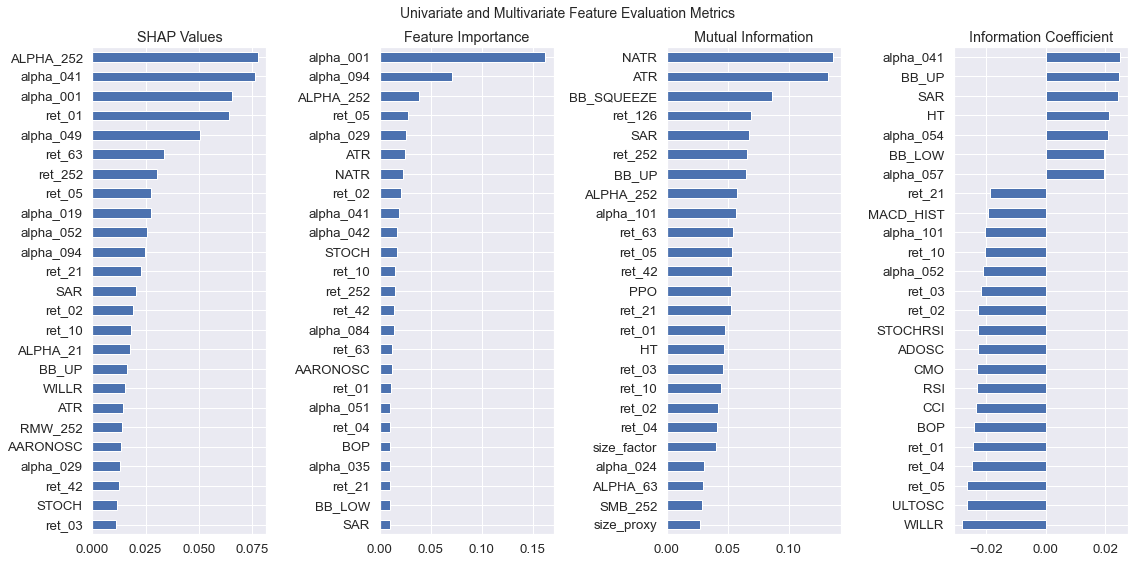

In [29]:
top_n = 25
fig, axes = plt.subplots(ncols=4, figsize=(16, 8))

shap_summary.nlargest(top_n).sort_values().plot.barh(ax=axes[0], title='SHAP Values')

fi.nlargest(top_n).sort_values().plot.barh(ax=axes[1], title='Feature Importance')

mi.nlargest(top_n).sort_values().plot.barh(ax=axes[2], title='Mutual Information')

top_corr = fwd_corr.abs().nlargest(top_n).index
fwd_corr.loc[top_corr].sort_values().plot.barh(ax=axes[3], title='Information Coefficient')

fig.suptitle('Univariate and Multivariate Feature Evaluation Metrics', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.91)
fig.savefig(results_path / 'all_feature_metrics');